# Traffic Simulation
## CS166 // Professor Scheffler
### Soren Gran // February 2019

......0.0.4.........2..4.............3...4......................4......4...........................4
...2..1.0.....4.......3....4............3....5......................4......4........................
.....1.01.........4......3.....4...........4......5.....................5......4....................
......00.2............4.....3......5...........5.......4.....................5.....5................
......01...2..............3....4........4...........5......4......................4.....4...........
......1.2....2...............4.....5........5............5.....4......................4.....4.......
.......1..2....3.................4......5........4............4....4......................5.....4...
4.......1...3.....4..................4.......4.......5............4....5.......................3....
....4....2.....3......4..................5.......5........4...........5.....5.....................4.
..4.....2..2......4.......5...................5.......4.......5............5.....5.........

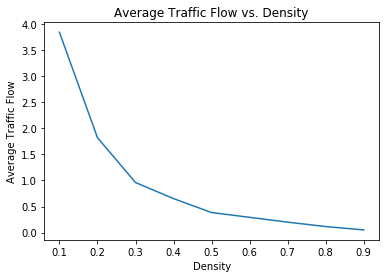

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

class TrafficSimulation():
    
    def __init__(self, road_length, density, max_veloc, prob):
        self.road_length = road_length # length of the road, even though it has periodic boundaries
        self.density = density # density of cars (occupied tiles/total tiles)
        self.max_veloc = max_veloc # maximum velocity allowed for cars (typically 5)
        self.prob = prob # probability of a car randomly slowing down
        self.num_cars = int(self.road_length*self.density) # number of cars in simulation
        
        self.traffic_flow = 0
        
        # creating the road
        self.road = np.zeros((self.road_length))
        for i in range(self.road_length):
            if i < self.num_cars:
                self.road[i] = self.max_veloc
                # we initialize all the first tiles as cars, for as many cars as we have
                # with max velocity
            else:
                self.road[i] = -1
                # all other tiles are empty
        np.random.shuffle(self.road) # but now we randomize the placement of the cars

    def closest(self, position):
        # checking where the nearest car is
        for i in range(1, self.max_veloc + 1):
            new_position = position + i
            if self.road[new_position % self.road_length] >= 0:
                return i
        return self.max_veloc + 1

    def move(self, road, position):
        if road[position] > 0: # we can only move cars with velocity
            new_position = position + int(road[position])
            road[new_position % self.road_length] = road[position]
            road[position] = -1
            
    def display(self): # this method taken from class
        print(''.join('.' if x == -1 else str(int(x)) for x in self.road))

    # defining a step of the simulation
    def step(self):
        for i in range(self.road_length): # for every tile, cars and not cars
            # first, will the car accelerate?
            if self.road[i] >= 0: # is a car here?
                if self.road[i] + 1 < self.closest(i):
                    if self.road[i] < self.max_veloc:
                        # if the car has room and its velocity is not max, it increases by 1
                        self.road[i] += 1
                elif self.road[i] >= self.closest(i):
                    # if the car does not have room, it reduces its speed to distance to next car - 1
                    if self.closest(i) > 0:
                        self.road[i] = self.closest(i) - 1
                    else:
                        self.road[i] = 0

                if np.random.random() < self.prob and self.road[i] > 0:
                    # the car may slow down randomly (as long as it is not stopped already)
                    self.road[i] -= 1
        
        # moving the car is complicated. If we use a simple for loop, we will reiterate over the same cars
        # as we move them forward. Thus, we must use a static list for iteration.
        temp_list = self.road.copy()
        self.display()
        for i in range(self.road_length):
            if temp_list[i] >= 0:
                self.move(self.road, i)
        
        total = 0
        for i in self.road:
            if i != -1:
                total += i
        self.traffic_flow = total/self.num_cars
        

        
def run_sim(road_length, density, max_veloc, prob, steps):
    simul = TrafficSimulation(road_length, density, max_veloc, prob)
    traffic_flows = []
    for i in range(steps):
        simul.step()
        traffic_flows.append(simul.traffic_flow)
    return np.mean(traffic_flows)

densities = [.1, .2, .3, .4, .5, .6, .7, .8, .9]
flows = []
for density in densities:
    flow = run_sim(100, density, 5, .5, 25)
    flows.append(flow)
plt.plot(densities, flows)
plt.xlabel("Density")
plt.ylabel("Average Traffic Flow")
plt.title("Average Traffic Flow vs. Density")
plt.show()
# The visualization seen depicts the cars and their velocities. Each number represents the 
# velocity of the car there. Periods represent empty spaces.

## Single-Lane Model Report
What did we see in this model? What assumptions did we make? The first assumption we made was the single lane nature of the model. Cars cannot change lanes and therefore cannot pass. Second, we set a parameter of a max speed and assumed nobody can exceed this speed. We assumed an absence of breakdowns/accidents that would cause serious traffic slowdowns. We assumed mostly optimal behavior of cars, except for random slowdowns (cars randomly decrease velocity by 1). If we had not included this random slowdown, we would see optimal driving and a lack of traffic jams.
A graph should appear at the bottom of the previous cell's output. What it shows is quite predictable - the average traffic flow decreases exponentially as the density increases. However, these results depend on the parameters. We had our most significant decrease from .1 to .2 density, but this would not occur if we had a longer road or lower max velocity. In a case like this, the cars would be able to spread more even at these densities and slowdowns would not occur until higher densities. However, the same shape of the graph will persist, which is negative exponential (except that the zero assymptote does not exist because we will reach 0 traffic flow at 100% density).


In [49]:
# Two lanes
# How do we maintain two lanes of traffic?
# Call two lists 0 and 1. Call the other list by doing 1 - list number.

# Same as original simulation, but with new rules.
# First, we update the car's velocity and lane.
# How?
# Step 1: Check if the car has room to accelerate in front of it. If it does, then stick with that.
# Step 2: If not, look at the other lane behind the car. Is there room to change lanes? If not, stay in
# the original lane and slow down.
# Step 3: If there is room, check if it is worth changing. Is there is more room in front in the other lane,
# change lanes and update accordingly.
# If not, update velocity accordingly in the same lane.

# Same code, but with changing lanes.
# The road is now two lanes in a list. That way, we can work with lane 1 as list[0] and lane 2 as list[1].

import numpy as np

class TwoLaneSimulation():
    
    def __init__(self, road_length, density, max_veloc, prob_slow, prob_switch, road = None):
        self.road_length = road_length # length of the road, even though it has periodic boundaries
        self.density = density # density of cars (occupied tiles/total tiles)
        self.max_veloc = max_veloc # maximum velocity allowed for cars (typically 5)
        self.prob_slow = prob_slow # probability of a car randomly slowing down
        self.prob_switch = prob_switch
        self.num_cars_per_lane = int(self.road_length*self.density) # number of cars in simulation
        
        # creating the road
        if road is not None:
            self.road = road
        else:
            self.road = np.zeros((2, self.road_length), dtype=int)
            for lane in self.road:
                for i in range(self.road_length):
                    if i < self.num_cars_per_lane:
                        lane[i] = self.max_veloc
                        # we initialize all the first tiles as cars, for as many cars as we have
                        # with max velocity
                    else:
                        lane[i] = -1
                        # all other tiles are empty
                np.random.shuffle(lane) # but now we randomize the placement of the cars
        

    def closest(self, lane, position): # lane is an index
        # checking where the nearest car is
        for i in range(1, self.max_veloc + 1):
            new_position = position + i
            if self.road[lane][new_position % self.road_length] >= 0:
                return i
        return self.max_veloc + 2

    def move(self, lane, position): # lane is an index
        if self.road[lane][position] > 0: # we can only move cars with velocity
            new_position = position + int(self.road[lane][position]) # this is where we will move, based on our velocity
            if self.road[lane][new_position % self.road_length] == -1:
                self.road[lane][new_position % self.road_length] = int(self.road[lane][position]) # moving the car forward
                self.road[lane][position] = -1 # emptying its previous location
            else:
                print("ERROR: TRIED TO MOVE TO OCCUPIED LOCATION", lane, position, new_position)
            
    
    def look_back(self, lane, position): # looks back in the OTHER lane. lane is an index.
        for i in range(self.max_veloc): # from 0 to max velocity
            new_position = position - i # this also checks the spot next to the car
            if self.road[1-lane][new_position % self.road_length] >= 0: # if there is a car in any
                # of the max veloc positions behind us
                # Why do we look back for the max veloc positions? That is because these cars
                # would not have time to slow down if they were going the max veloc and we changed lanes
                # and stopped. If they are max_veloc + 1 positions back, they have time to stop.
                return False # then we can't change lanes
        return True # if there is not, then we are free to change lanes
    
    def switch_lane(self, lane, position): # lane is an index
        if self.road[1-lane][i] == -1:
            self.road[1-lane][i] = int(self.road[lane][i]) # we move to the same position in the other lane
            self.road[lane][i] = -1 # we empty our former position
        else:
            print('ERROR: TRIED TO SWITCH LANES TO OCCUPIED POSITION', lane, position, self.road[lane][position], self.road[1-lane][position])

    def display(self):
        for lane in self.road:
            print(''.join('.' if x == -1 else str(int(x)) for x in lane))
        print('\n')

    # defining a step of the simulation
    
    def step(self):
        states = np.zeros((2, self.road_length), dtype=int) # tells us if a car will switch lanes or not
        for lane in [0, 1]: # these indices represent our lanes
            for pos in range(self.road_length):
                # first, we have to update the velocities of car
                if self.road[lane][pos] != -1: # if there is a car here
                    if self.road[lane][pos] + 1 < self.closest(lane, pos): # if we have space to accelerate
                        if self.road[lane][pos] < self.max_veloc: # if current veloc < max veloc
                            self.road[lane][pos] += 1 # accelerate
                        
                        if np.random.random() < self.prob_slow and self.road[lane][pos] > 0: # random slowdown
                            self.road[lane][pos] -= 1
                    
                    elif self.look_back(lane, pos) and self.closest(lane, pos) < self.closest(1-lane, pos) and np.random.random() < self.prob_switch:
                        # if we have space to change lanes (next to and behind), it is worth changing (more space in other lane),
                        # and we do not randomly choose not to change lanes
                        states[lane][pos] = 1 # we are changing lanes
                        
                        if self.road[lane][pos] + 1 < self.closest(1-lane, pos): # room to accelerate?
                            if self.road[lane][pos] < self.max_veloc: # current velocity < max velocity?
                                self.road[lane][pos] += 1 # accelerate
                        
                        elif self.closest(1-lane, pos) > 0: # making sure we don't decelerate from 0
                            self.road[lane][pos] = self.closest(1-lane, pos) - 1
                        
                        else:
                            self.road[lane][pos] = 0
                        
                        if np.random.random() < self.prob_slow and self.road[lane][pos] > 0: # random slowdown
                            self.road[lane][pos] -= 1
                    
                    else: # staying in our lane
                        if self.closest(lane, pos) > 0: # making sure we don't decelerate from 0
                            self.road[lane][pos] = self.closest(lane, pos) - 1 # deceleration (or remaining constant)
                        else:
                            self.road[lane][pos] = 0
                        
                        if np.random.random() < self.prob_slow and self.road[lane][pos] > 0: # random slowdown
                            self.road[lane][pos] -= 1

        for lane in [0, 1]:
            for pos in range(self.road_length):
                if states[lane][pos] == 1: # changing lanes of the cars that need to change lanes
                    self.switch_lane(lane, pos)
        
        temp_list = self.road.copy() # we need to make a copy so that we don't repeatedly move a car
        self.display()
        for lane in [0, 1]: # for each lane
            for pos in range(self.road_length): # for each position
                if temp_list[lane][pos] > 0: # if it is a car
                    self.move(lane, pos) # move it
        self.display()
        
        # this next bit is me trying to figure out my bug (explained later)
        count = 0
        for lane in [0, 1]:
            for pos in self.road[lane]:
                if pos != -1:
                    count += 1
        print(count)
        
        
    



simulation1 = TwoLaneSimulation(100, .2, 5, .1, .5)
for i in range(25):
    simulation1.step()



ERROR: TRIED TO SWITCH LANES TO OCCUPIED POSITION 0 75 4 -1
ERROR: TRIED TO SWITCH LANES TO OCCUPIED POSITION 1 40 5 -1
2......5......5......04....1.01.5..............5......2..5........2..3...1.4..4....3...5........1.5.
...3.1.5.......3...5........5...........55......1.2..4....2..2..5...............005.......5.....3...


ERROR: TRIED TO MOVE TO OCCUPIED LOCATION 1 5 6
..25........5......5.0....4.10.1.....5..............5...2.....5.....2...3.1....4..4...3.....5....1..
.....13.....5.....3.....5........5...........55..1..2....4..2..2.....5..........00.....5.......5...3


40
..05........5......1.1....1.01.2.....5..............2...3.....5.....3...1.2....2..2...3.....4....2..
.....04.....5.....4.....5........5...........05..1..3....2..2..2.....5..........01.....5.......3...4


..0.....5........5..1.1....10.1..2........5...........2....3.......5...3.1..2....2..2....3......4..2
...4.0....4......5....4......5........5......0....15...3...2..2..2........5.....0.1.........5.....3.


40
........5.

## Two Lane Decision Tree when updating velocity
                                Is there a car here?
                                        /      \
                                      yes      no --> no velocity to update
                                      /
                                 does it have space to accelerate?
                                 /          \
    if < max_vel, accelerate <--  yes          no
                                             \
    Is there space to change lanes AND is it worth changing (more space in other lane) AND do we not randomly not change lanes?
                            /                   \
                          yes                   no --> stay in lane, decelerate or keep veloc
                          /
                        change lanes
                        /
                        space to accelerate?
                            /            \
    accel (if < max) <--   yes           no --> decelerate or keep veloc

## Explanation of Two Lane Simulation
I had a bug that persisted for the entire weekend. The bug was that cars would occasionally disappear. I rewrote my code multiple times, asked all of my friends to look for the bug, and could not find it. Because of that, I was not able to gather reliable data about this simulation's traffic flow, since its flow would change artificially as cars drop off.